In [1]:
import numpy as np
import sys
sys.path.insert(1,'../../src')
from _generate_time_series import *
from _shear_frame import *
from utils_OB import *
from _clustering import *
import _tracking as tk
from utils_JK import *
import seaborn as sns
sns.set_theme(context='paper',font_scale=1.0, style = 'ticks', color_codes='deep')

%load_ext autoreload
%autoreload 2

In [64]:
# stiffness and mass: 
kx=np.array([2,2])*4000
ky=kx
m=np.array([1,1])*500

n=150  #number of time series to run

#shapes for how the stiffnesses should behave trougout the time series:
base_shapey=np.hstack((np.linspace(1.5,1.3,n//2),np.linspace(1,1.3,n-n//2)))
base_shapex=np.sin(2*np.pi*base_shapey*20)*0.03+base_shapey

shapey=np.vstack((base_shapey,base_shapey**2))
shapex=np.vstack((base_shapex,base_shapex**0.5+0.4))
# shapey[1] += 0.6
#What modal orders to run in the cov-ssi:
orders=np.arange(2,50,1)

#sampling frequency and lengt of each time series:
fs=7        #Hz
T_max=3000  #sec
t=np.arange(0,T_max,1/fs)

# specify parameters for the load series: 
    # the general input for the amplutide of the white noise
white_noise_amp=1
    # whether or not to create new load series for each time segment
next_segment='new'
    #whether or not to greate indeviduel loadings for all DOFS
next_DOF='new'
    #Whether or not to include a harmonic part in the loading, and what type of 
    #harmonic function
harmonic=None
    #the the factor the amplitude of the harmonic is multiplied with 
    #the amplitude of the white noise
harmonic_part=0.2

### Noise fac for added measurments noice: 
noise_fac=1

#Number of times to run the
n_sim = 40

valid_range= { 'freq': [1e-4, np.inf],'damping': [1e-4,np.inf] }

indicator='freq'
s=1
stabcrit = {'freq':0.05, 'damping': 0.1, 'mac': 0.1}
prob_threshold = 0.5   #probability of pole to belong to 
# cluster, based on estimated "probability" density function

min_cluster_size=35 
min_samples=12
scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0}

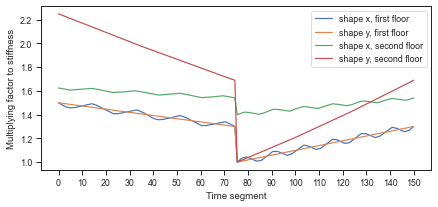

In [65]:
fig,ax = plt.subplots(figsize=(7,3))
ax.plot(np.linspace(0,n,n),shapex[0],label='shape x, first floor')
ax.plot(np.linspace(0,n,n),shapey[0], label='shape y, first floor')
ax.plot(np.linspace(0,n,n),shapex[1],label='shape x, second floor')
ax.plot(np.linspace(0,n,n),shapey[1], label='shape y, second floor')
ax.set_xlabel('Time segment')
ax.set_xticks(np.arange(0, 151, 10))
ax.set_ylabel('Multiplying factor to stiffness')
ax.legend()

In [10]:
savefig_dir_name = './test_results/'
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(savefig_dir_name))

FileNotFoundError: [WinError 2] Systemet finner ikke angitt fil: './test_results'

In [11]:
for run_i in range(n_sim):
    true_w,true_phi,responses=generate_dynamic_series(kx,ky,shapex,shapey,m,t,
                                           white_noise_amp=white_noise_amp
                                           ,next_segment=next_segment
                                           ,next_DOF=next_DOF
                                           ,harmonic=harmonic
                                           ,harmonic_part=harmonic_part
                                           ,plot=False)
    
    lambds,phis=create_input_COVssi(responses,t,orders)

    ys=create_output_guassian(lambds)

    til_jon=ys.T

    #np.savez('test_3_run_'+str(run_i)+'_favarelli',til_jon)

    phis_out,ws_out=clustering(lambds,
    phis,orders,s,stabcrit,valid_range,indicator,prob_threshold,
    scaling,min_cluster_size,min_samples,true_w=true_w,plot=False)

    id_sort = np.argsort(true_w[0])
    true_w_sorted = true_w[:,id_sort]
    true_phi_sorted = true_phi[id_sort,:,:]
    true_f_sorted = true_w_sorted/(2*np.pi)

    freqs_out = radtoHz(ws_out)

    if run_i == 0: 
        np.savez('test_3_true',true_f_sorted,true_phi_sorted)
        break
    np.savez('test_3_run_'+str(run_i+10),freqs_out,phis_out)